# Cybersecurity Threat Classification Using Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Defining palette
colors = ['#2C3E50', '#E74C3C', '#3498DB', '#2ECC71', '#F39C12']
model_colors = {'Random Forest': '#3498DB', 
                'SVM': '#2ECC71', 
                'Neural Network': '#F39C12'}

# Reading the CSV Files

Training set shape: (25192, 42)
Test set shape: (22544, 41)

Missing values in training data:
0

Class distribution in training data:
class
normal     13449
anomaly    11743
Name: count, dtype: int64


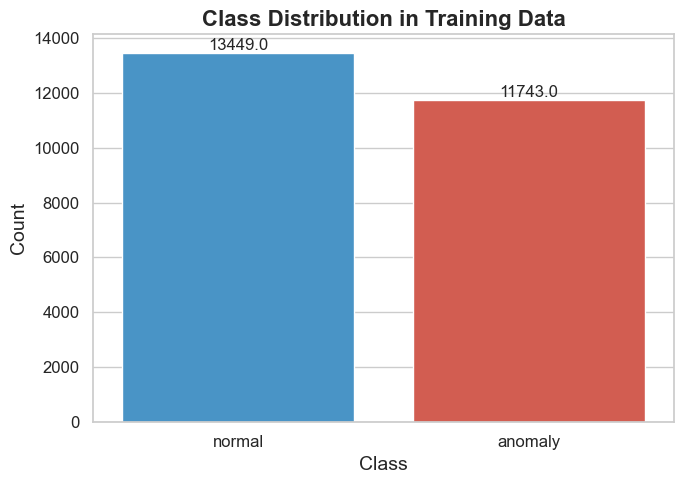

In [2]:
# Load the data
train_data = pd.read_csv('Train_data.csv')
test_data = pd.read_csv('Test_data.csv')

# Print basic information
print(f"Training set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")

# Check for missing values
print("\nMissing values in training data:")
print(train_data.isnull().sum().sum())

# Display class distribution (target variable)
print("\nClass distribution in training data:")
class_counts = train_data['class'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='class', data=train_data, palette=['#3498DB', '#E74C3C'])
plt.title('Class Distribution in Training Data', fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)
plt.tight_layout()
#plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Data Preprocessing

In [3]:
# Function to preprocess data
def preprocess_data(df, is_training=True):
    # Create a copy to avoid modifying the original
    data = df.copy()
    
    # Separate features from target for training data
    if is_training:
        X = data.drop('class', axis=1)
        y = data['class']
        # Convert target to binary (normal=0, anomaly=1)
        y = y.apply(lambda x: 0 if x == 'normal' else 1)
    else:
        X = data.copy()
        y = None
    
    # Get categorical columns
    cat_cols = X.select_dtypes(include=['object']).columns
    
    # Convert categorical features using one-hot encoding
    X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    # Scale numerical features
    scaler = StandardScaler()
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])
    
    if is_training:
        return X_encoded, y
    else:
        return X_encoded

# Preprocess training data
X_train_full, y_train_full = preprocess_data(train_data)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")

Training features shape: (20153, 115)
Validation features shape: (5039, 115)


# Feature Selection

Number of selected features: 30
Selected features:
Index(['wrong_fragment', 'logged_in', 'count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'protocol_type_udp', 'service_Z39_50',
       'service_domain_u', 'service_eco_i', 'service_ecr_i', 'service_http',
       'service_private', 'service_smtp', 'flag_REJ', 'flag_RSTR', 'flag_S0',
       'flag_SF'],
      dtype='object')


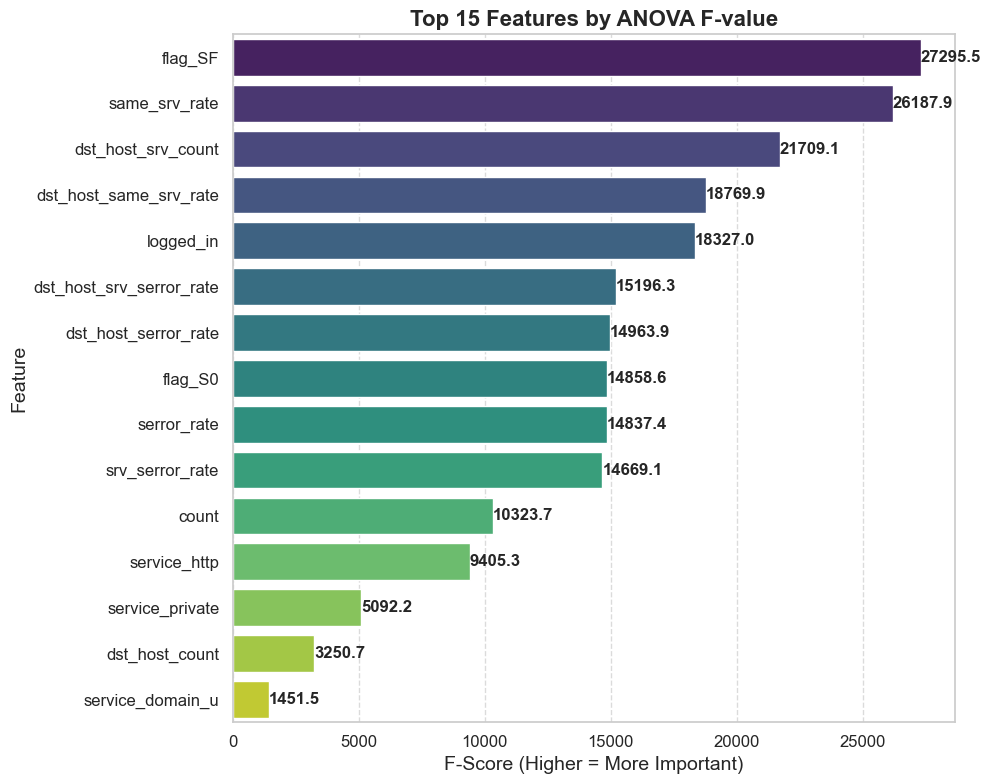

In [4]:
# Select top k features based on ANOVA F-value
def select_features(X_train, y_train, X_val, k=20):
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    
    # Get selected feature names
    selected_features = X_train.columns[selector.get_support()]
    
    return X_train_selected, X_val_selected, selected_features, selector

# Apply feature selection
X_train_selected, X_val_selected, selected_features, selector = select_features(X_train, y_train, X_val, k=30)

print(f"Number of selected features: {len(selected_features)}")
print("Selected features:")
print(selected_features)

# Visualize feature importance scores
feature_scores = pd.DataFrame({'Feature': X_train.columns, 'Score': selector.scores_})
top_features = feature_scores.sort_values('Score', ascending=False).head(15)

plt.figure(figsize=(10,8))
ax = sns.barplot(x='Score', y='Feature', data=top_features, palette='viridis')
plt.title('Top 15 Features by ANOVA F-value', fontweight='bold')
plt.xlabel('F-Score (Higher = More Important)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add score values on bars
for i, v in enumerate(top_features['Score']):
    ax.text(v + 0.5, i, f'{v:.1f}', va='center', fontweight='bold')

plt.tight_layout()
#plt.savefig('feature_importance_anova.png', dpi=300, bbox_inches='tight')
plt.show()

# Model Training - Random Forest

Random Forest Accuracy: 0.9917
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2690
           1       0.99      0.99      0.99      2349

    accuracy                           0.99      5039
   macro avg       0.99      0.99      0.99      5039
weighted avg       0.99      0.99      0.99      5039



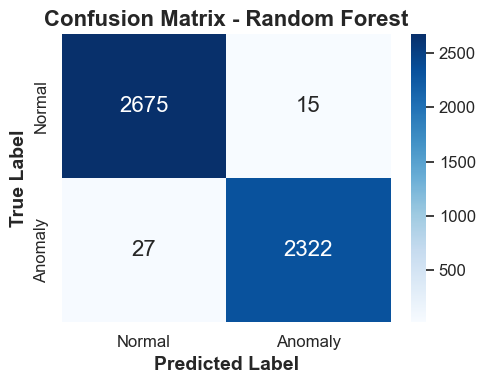

In [5]:
# Define and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_val_selected)
y_pred_prob_rf = rf_model.predict_proba(X_val_selected)[:, 1]

# Calculate metrics
accuracy_rf = accuracy_score(y_val, y_pred_rf)
report_rf = classification_report(y_val, y_pred_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("Random Forest Classification Report:")
print(report_rf)

# Plot confusion matrix
cm_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            annot_kws={"size": 16})
plt.title('Confusion Matrix - Random Forest', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
#plt.savefig('confusion_matrix_rf.png', dpi=300, bbox_inches='tight')
plt.show()

# Model Training - SVM

SVM Accuracy: 0.9794
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2690
           1       0.99      0.96      0.98      2349

    accuracy                           0.98      5039
   macro avg       0.98      0.98      0.98      5039
weighted avg       0.98      0.98      0.98      5039



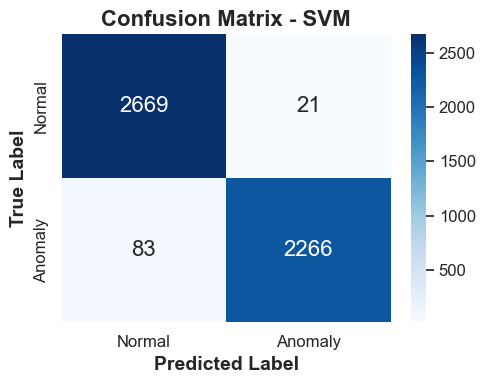

In [6]:
# Define and train the SVM model
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_selected, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_val_selected)
y_pred_prob_svm = svm_model.predict_proba(X_val_selected)[:, 1]

# Calculate metrics
accuracy_svm = accuracy_score(y_val, y_pred_svm)
report_svm = classification_report(y_val, y_pred_svm)
fpr_svm, tpr_svm, _ = roc_curve(y_val, y_pred_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

print(f"SVM Accuracy: {accuracy_svm:.4f}")
print("SVM Classification Report:")
print(report_svm)

# Plot confusion matrix
cm_svm = confusion_matrix(y_val, y_pred_svm)
plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            annot_kws={"size": 16})
plt.title('Confusion Matrix - SVM', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
#plt.savefig('confusion_matrix_svm.png', dpi=300, bbox_inches='tight')
plt.show()

# Model Training - Neural Network

Neural Network Accuracy: 0.9879
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2690
           1       0.99      0.99      0.99      2349

    accuracy                           0.99      5039
   macro avg       0.99      0.99      0.99      5039
weighted avg       0.99      0.99      0.99      5039



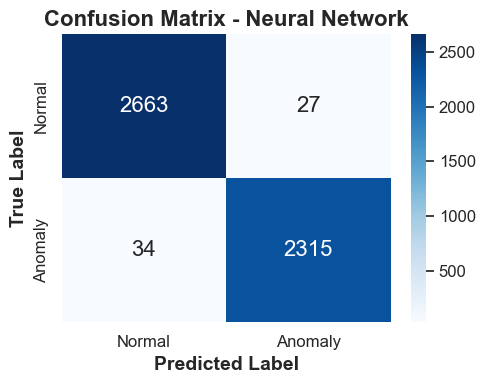

In [7]:
# Define and train the Neural Network model
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
nn_model.fit(X_train_selected, y_train)

# Make predictions
y_pred_nn = nn_model.predict(X_val_selected)
y_pred_prob_nn = nn_model.predict_proba(X_val_selected)[:, 1]

# Calculate metrics
accuracy_nn = accuracy_score(y_val, y_pred_nn)
report_nn = classification_report(y_val, y_pred_nn)
fpr_nn, tpr_nn, _ = roc_curve(y_val, y_pred_prob_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

print(f"Neural Network Accuracy: {accuracy_nn:.4f}")
print("Neural Network Classification Report:")
print(report_nn)

# Plot confusion matrix
cm_nn = confusion_matrix(y_val, y_pred_nn)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            annot_kws={"size": 16})
plt.title('Confusion Matrix - Neural Network', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
#plt.savefig('confusion_matrix_nn.png', dpi=300, bbox_inches='tight')
plt.show()

# Model Comparison

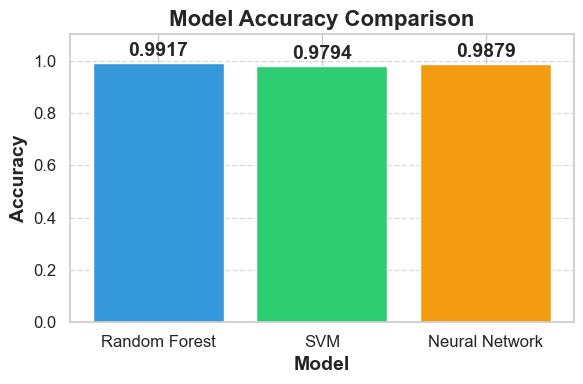

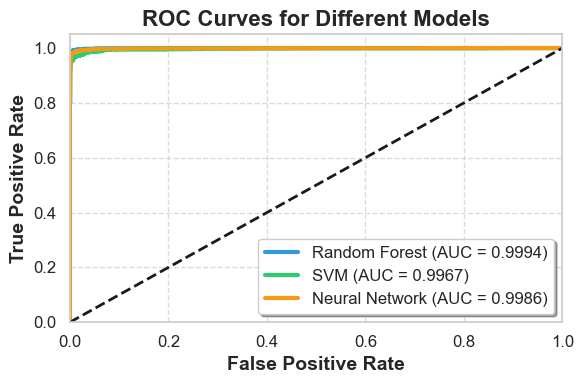

In [8]:
# Compare accuracy of all models
models = ['Random Forest', 'SVM', 'Neural Network']
accuracies = [accuracy_rf, accuracy_svm, accuracy_nn]
reports = [report_rf, report_svm, report_nn]

plt.figure(figsize=(6, 4))
bars = plt.bar(models, accuracies, color=[model_colors[name] for name in models])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=14)

plt.title('Model Accuracy Comparison', fontweight='bold')
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.savefig('model_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot ROC curves for all models
plt.figure(figsize=(6,4))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})', color=model_colors['Random Forest'], linewidth=3)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.4f})', color=model_colors['SVM'], linewidth=3)
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.4f})', color=model_colors['Neural Network'], linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curves for Different Models', fontweight='bold')
plt.legend(loc="lower right", frameon=True, fancybox=True, shadow=True)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance Analysis

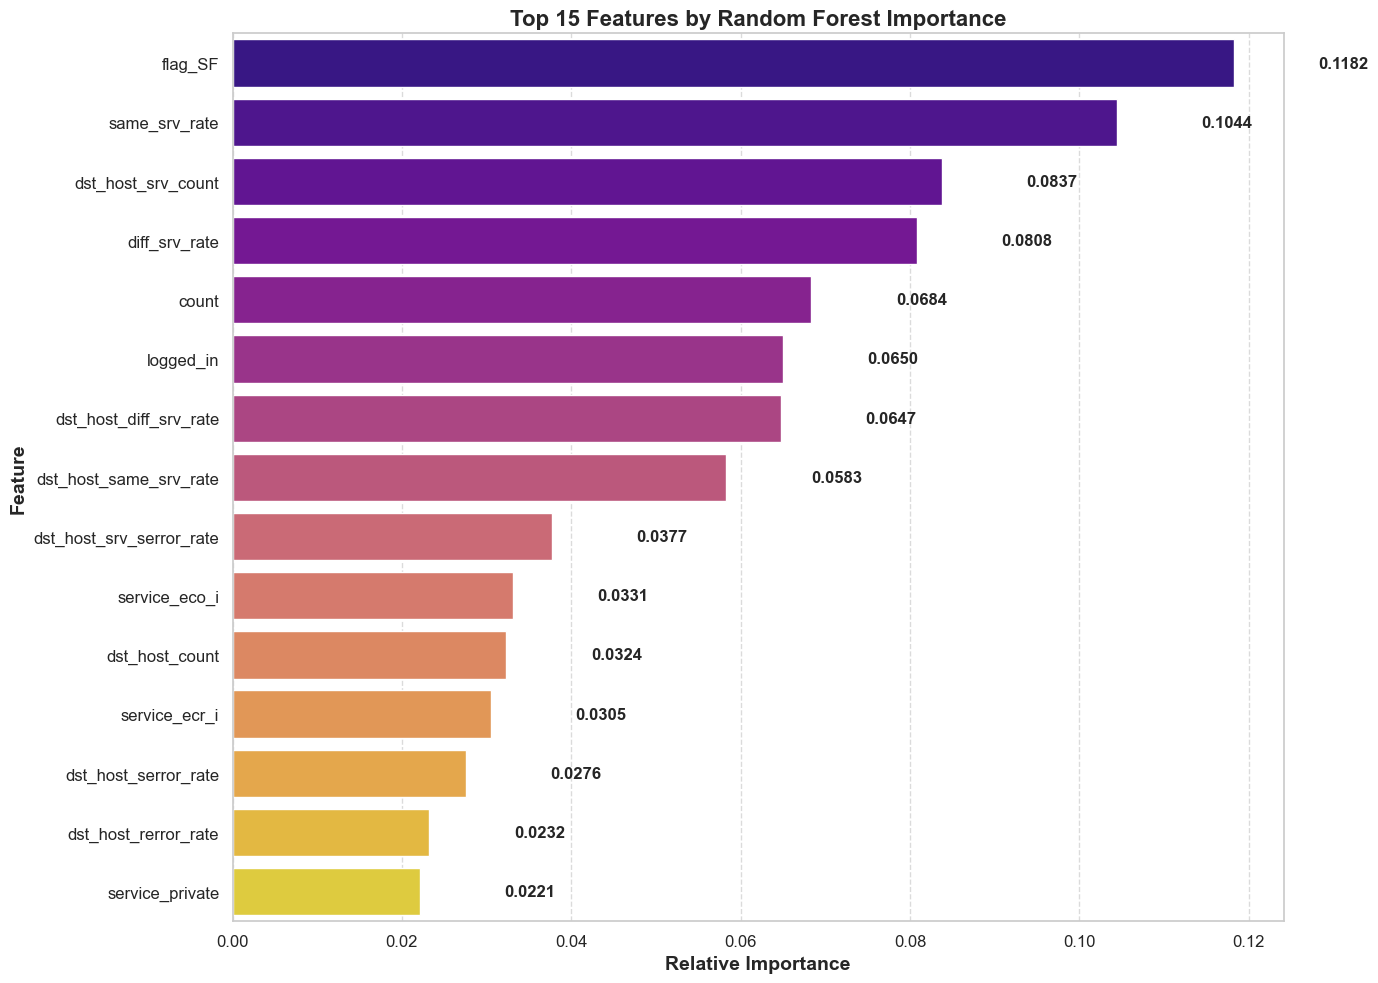

In [9]:
# Ensure the results dictionary is defined and populated with the models and results
results = {
    'Random Forest': {
        'model': rf_model
    }
}

# Analyze feature importance from Random Forest
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    
    # Get feature importance
    importances = rf_model.feature_importances_
    
    # Create a DataFrame for better visualization
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Plot top features
    plt.figure(figsize=(14, 10))
    ax = sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='plasma')
    plt.title('Top 15 Features by Random Forest Importance', fontweight='bold')
    plt.xlabel('Relative Importance', fontweight='bold')
    plt.ylabel('Feature', fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add importance values on bars
    for i, v in enumerate(feature_importance.head(15)['Importance']):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')
    
    plt.tight_layout()
    #plt.savefig('feature_importance_rf.png', dpi=300, bbox_inches='tight')
    plt.show()

# Predict on Test Data


First few test predictions:
   Prediction  Probability    Class
0           1         0.93  anomaly
1           1         0.93  anomaly
2           0         0.09   normal
3           1         0.60  anomaly
4           0         0.42   normal
5           0         0.03   normal
6           0         0.18   normal
7           0         0.18   normal
8           0         0.03   normal
9           0         0.14   normal

Prediction counts:
Class
normal     14087
anomaly     8457
Name: count, dtype: int64


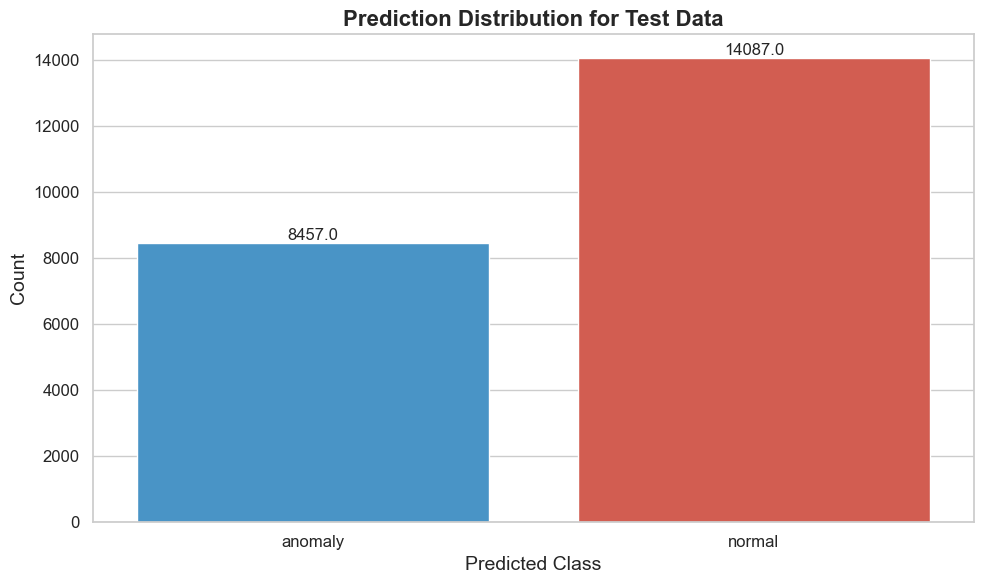


Results saved to 'predictions.csv' and 'test_data_with_predictions.csv'


In [10]:
# Process and make predictions on test data
if 'class' not in test_data.columns:
    X_test = preprocess_data(test_data, is_training=False)
    
    # Make sure we select the same features as we did for training
    try:
        X_test_selected = selector.transform(X_test)
    except ValueError:
        # If test data has different columns, align it with training data
        missing_cols = set(X_train.columns) - set(X_test.columns)
        for col in missing_cols:
            X_test[col] = 0
        X_test = X_test[X_train.columns]
        X_test_selected = selector.transform(X_test)
    
    # Choose best model (RF usually performs well)
    best_model = results['Random Forest']['model']
    
    # Make predictions
    test_predictions = best_model.predict(X_test_selected)
    test_prediction_probs = best_model.predict_proba(X_test_selected)[:, 1]
    
    # Create output DataFrame
    output = pd.DataFrame({
        'Prediction': test_predictions.astype(int),
        'Probability': test_prediction_probs
    })
    
    # Map predictions to original class names
    output['Class'] = output['Prediction'].map({0: 'normal', 1: 'anomaly'})
    
    # 1. A file with just the predictions
    output.to_csv('predictions.csv', index=False)
    
    # 2. A file with the original test data plus predictions
    test_with_predictions = pd.concat([test_data.reset_index(drop=True), output], axis=1)
    test_with_predictions.to_csv('test_data_with_predictions.csv', index=False)
    
    print("\nFirst few test predictions:")
    print(output.head(10))
    print("\nPrediction counts:")
    print(output['Class'].value_counts())
    
    # Visualize prediction distribution
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='Class', data=output, palette=['#3498DB', '#E74C3C'])
    plt.title('Prediction Distribution for Test Data', fontweight='bold')
    plt.xlabel('Predicted Class')
    plt.ylabel('Count')
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', 
                    (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='bottom', fontsize=12)
    
    plt.tight_layout()
    #plt.savefig('test_predictions_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nResults saved to 'predictions.csv' and 'test_data_with_predictions.csv'")
else:
    print("\nTest data already contains 'class' column. Treating it as a validation set.")